In [1]:
import pandas as pd
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm
import numpy as np
import torch
import os
import matplotlib.pyplot as plt

In [ ]:

os.environ["TOKENIZERS_PARALLELISM"] = "false"

#post_process = pipeline("sentiment-analysis").postprocess
tokenizer = AutoTokenizer.from_pretrained("pysentimiento/robertuito-sentiment-analysis")
model = AutoModelForSequenceClassification.from_pretrained("pysentimiento/robertuito-sentiment-analysis")
model.eval().cuda()

# sentiment_pipeline = pipeline("sentiment-analysis","finiteautomata/bertweet-base-sentiment-analysis",
 #truncation=True,
 #  device='cuda:0',
 #  batch_size=1024)
# print(sentiment_pipeline.postprocess())
# print(sentiment_pipeline.tokenizer)
# print(sentiment_pipeline._batch_size)
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, enc1, enc2, enc3):
        # print(len(encodings))
        self.enc1 = enc1
        self.enc2 = enc2
        self.enc3 = enc3
    def __len__(self):
        return len(self.enc1)
    def __getitem__(self, i):
        item = {'input_ids': torch.tensor(self.enc1[i]),
        'token_type_ids': torch.tensor(self.enc2[i]),
        'attention_mask': torch.tensor(self.enc3[i])}
        # item = {key: torch.tensor(val[i], requires_grad=False) for key, val in self.encodings.items()}
        return item

def sent_analysis(desc):
    # print(len(desc))
    encodings = tokenizer(desc, truncation=True, max_length=128, padding=True)
    dataset = MyDataset(encodings['input_ids'],
    encodings['token_type_ids'],
    encodings['attention_mask'])
    params = {'batch_size': 1024, 'shuffle': False, 'num_workers': 8}
    training_generator = torch.utils.data.DataLoader(dataset, **params)
    outs = []
    for bt in tqdm(training_generator):
        bt = {key: val.cuda() for key, val in bt.items()}
        with torch.no_grad():
            out = model(**bt)
            scores = torch.nn.functional.softmax(out['logits'], dim=1).detach().cpu().numpy()
        outs.append(scores)
    outs = np.concatenate(outs, axis=0)
    outs = np.concatenate([outs[:,0:1],outs[:,2:]], axis=1)
    clss = np.argmax(outs, axis=1)
    lbl = np.array(clss)
    lbl[clss == 0] = -1
    lbl[clss == 1] = 1
    #lbl[clss == 2] = 1 
    return lbl * np.max(outs, axis=1)


In [ ]:
chunksize = (10 ** 6) // 2
flag=False
for chunk in tqdm(pd.read_json("data/yt_metadata_en.jsonl.gz",lines=True, chunksize=chunksize)): 
    # chunk = chunk.loc[chunk["categories"].isin(['Nonprofits & Activism', 'People & Blogs', 'News & Politics'])]
    drop_indices = np.random.choice(chunk.index, int(0.8*chunksize), replace=False)
    chunk = chunk.drop(drop_indices)
    dsc = chunk['description'].to_list()
    chunk = chunk.drop(['crawl_date', 'duration', 'description', 'tags', 'title'], axis=1)

    out = sent_analysis(dsc)
    #sentiment = pd.DataFrame.from_dict(out)
    #sentiment['label'] = sentiment['label'].map({'POS': 1.,'NEU':0., 'NEG': -1.})
    #sentiment['score'] = sentiment['label']*sentiment['score']
    chunk['sent'] = out
    chunk['heat_metric'] = chunk['dislike_count'] / (chunk['like_count'] + chunk['dislike_count'])
    print(chunk.head())
    if not flag:
        flag=True
        chunk.to_csv('data_reduced/yt_metadata_reduced2.tsv.gz', index=False)
    else:
        chunk.to_csv('data_reduced/yt_metadata_reduced2.tsv.gz', index=False, header=False, mode='a')
    


In [2]:
dt = pd.read_csv('data_reduced/yt_metadata_reduced2.tsv.gz')
dt.head()


/home/ewais/anaconda3/envs/deca-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (2,5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,categories,channel_id,dislike_count,display_id,like_count,upload_date,view_count,sent,heat_metric
0,Film & Animation,UCzWrhkg9eK5I8Bm3HfV-unA,0.0,C_dN36VjbZA,13.0,2016-09-26 00:00:00,10024.0,0.974387,0.000000
1,Film & Animation,UCzWrhkg9eK5I8Bm3HfV-unA,0.0,5-Z8nVPZ6l8,21.0,2016-09-23 00:00:00,7313.0,0.927599,0.000000
2,Film & Animation,UCzWrhkg9eK5I8Bm3HfV-unA,2.0,HYwEVBvedG8,15.0,2016-09-21 00:00:00,14563.0,0.979274,0.117647
3,Film & Animation,UCzWrhkg9eK5I8Bm3HfV-unA,0.0,FToHbfewMPQ,8.0,2016-09-20 00:00:00,344.0,0.972839,0.000000
4,Film & Animation,UCzWrhkg9eK5I8Bm3HfV-unA,0.0,9zhYO3tjGhg,10.0,2016-09-18 00:00:00,840.0,0.967177,0.000000


In [3]:
from datetime import datetime
dt['upload_date'] = pd.to_datetime(dt['upload_date'], errors='coerce')
dt = dt.loc[dt['upload_date']>=datetime(2008,1,1)]
dt = dt.loc[dt['categories'] != 'Shows']

/home/ewais/anaconda3/envs/deca-env/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  import sys


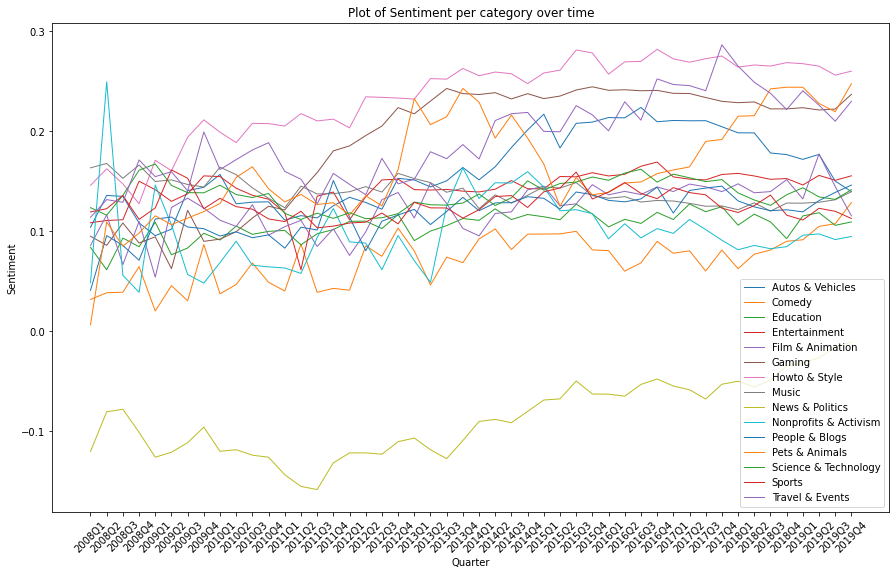

In [8]:
import seaborn as sns


grp_cat = dt.groupby(['categories'])
fig = plt.figure(figsize=(15, 9))
ax = fig.add_subplot(111)
ax.set_xticklabels(dt.groupby(pd.PeriodIndex(dt['upload_date'], freq="Q"))['sent'].mean().index.map(str).to_list(), rotation=45)
for grp in grp_cat:
    # grp.groupby()
    sent_mean = grp[1].groupby(pd.PeriodIndex(grp[1]['upload_date'], freq="Q"))['sent'].mean()
    sent_mean = pd.DataFrame({'mean_sent' : sent_mean}).reset_index()
    sent_mean = sent_mean.set_index('upload_date').resample('Q').asfreq().fillna(0)
    ax.plot(sent_mean.index.map(str).to_list(), sent_mean['mean_sent'].to_list(), linewidth=1, label=grp[0])
    
    

plt.xlabel('Quarter')
plt.ylabel('Sentiment')
plt.title('Plot of Sentiment per category over time')
plt.legend()
plt.show()


# dt_new = dt.loc[dt['upload_date']>=datetime(2015,1,1)]


Text(0.5, 1.0, 'Sentiment Per Category')

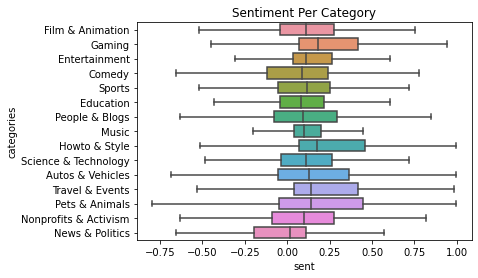

In [5]:
sns.boxplot(data=dt, y="categories", x="sent", showfliers=False).set_title('Sentiment Per Category')

Text(0.5, 1.0, 'Heat Per Category')

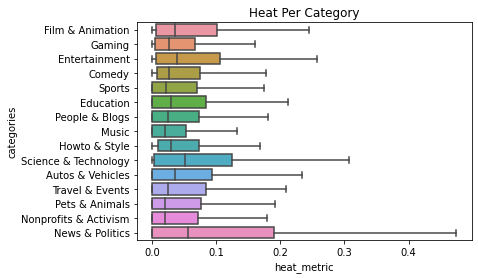

In [6]:
sns.boxplot(data=dt, y="categories", x="heat_metric", showfliers=False).set_title('Heat Per Category')

/home/ewais/anaconda3/envs/deca-env/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  after removing the cwd from sys.path.


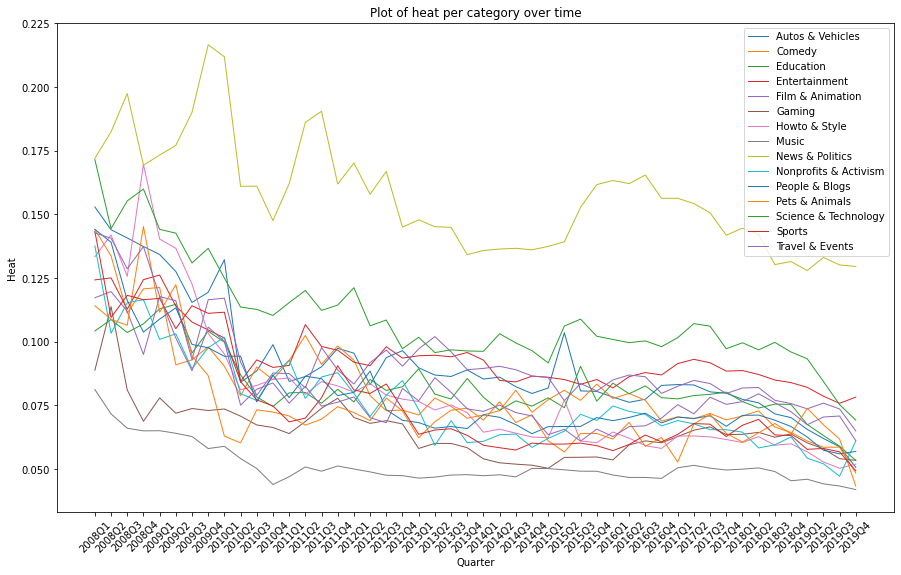

In [7]:
grp_cat = dt.groupby(['categories'])
fig = plt.figure(figsize=(15, 9))
ax = fig.add_subplot(111)
ax.set_xticklabels(dt.groupby(pd.PeriodIndex(dt['upload_date'], freq="Q"))['heat_metric'].mean().index.map(str).to_list(), rotation=45)
for grp in grp_cat:
    if grp[0] == 'Shows':
        continue
    # grp.groupby()
    sent_mean = grp[1].groupby(pd.PeriodIndex(grp[1]['upload_date'], freq="Q"))['heat_metric'].mean()
    sent_mean = pd.DataFrame({'mean_heat' : sent_mean}).reset_index()
    sent_mean = sent_mean.set_index('upload_date').resample('Q').asfreq().fillna(0)
    ax.plot(sent_mean.index.map(str).to_list(), sent_mean['mean_heat'].to_list(), linewidth=1, label=grp[0])
    
    

plt.xlabel('Quarter')
plt.ylabel('Heat')
plt.title('Plot of heat per category over time')
plt.legend()
plt.show()
